In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
tickers = ['xle', 'xlu', 'xlb', 'xlk', 'xli', 'xlv', 'xlf', 'xlp', 'xly']
end_date = '2023-07-16'

In [3]:
price_dataframe = yf.download(tickers, end=end_date)['Close']

preprocessed_dataframe = price_dataframe.fillna(method='ffill')
preprocessed_dataframe = preprocessed_dataframe.dropna()

[*********************100%***********************]  9 of 9 completed


In [4]:
normalizedDataframe = preprocessed_dataframe.pct_change().dropna()

In [5]:
lookbacks = np.arange(2, (21*12)+1, 1)

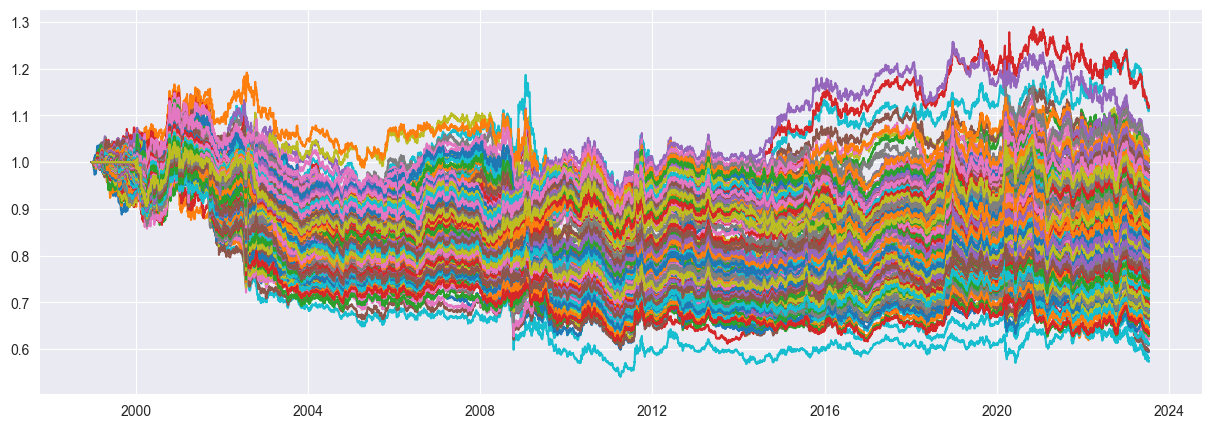

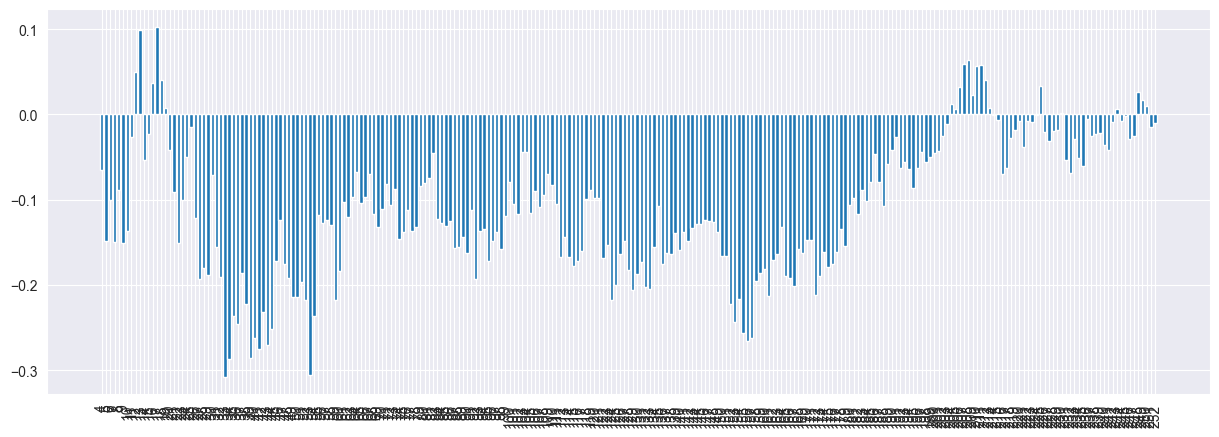

In [14]:
def backtest(dataframe, lookbacks, sharpes):
    for lookback in lookbacks:
        weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

        signal = dataframe.rolling(lookback).std()
        signal = signal.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
        signal = np.sign(signal)
        signal *= -1

        weighted_signal = signal.mul(weights)

        portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)

        cumulative_returns = (portfolio_returns + 1).cumprod()

        plt.plot(cumulative_returns)

        # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
        sharpes.append((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))

    # plt.legend(lookbacks)
    plt.show()

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)

    # sns.heatmap(np.array(sharpes).reshape(len(lookbacks), len(lookbacks)), xticklabels=lookbacks, yticklabels=lookbacks)
    # plt.show()

backtest(normalizedDataframe, lookbacks, [])

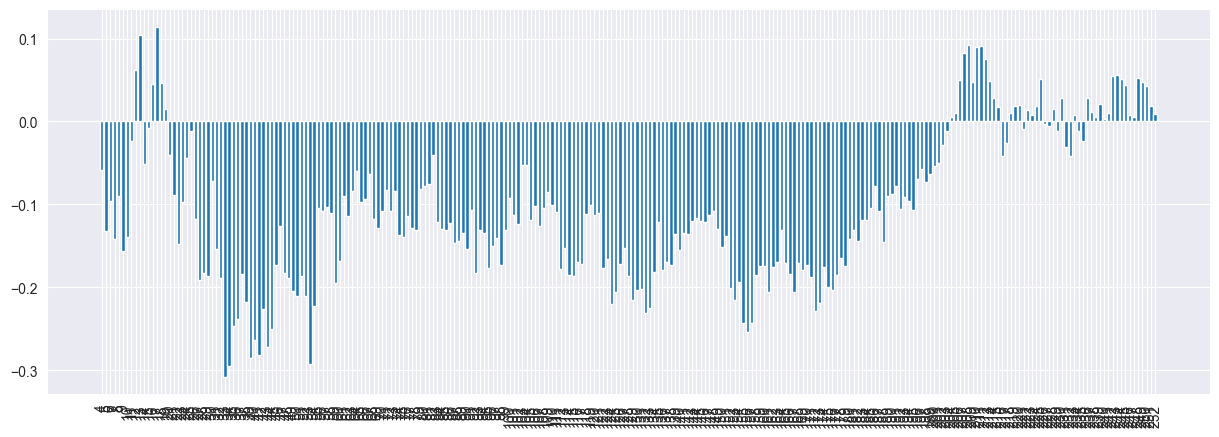

In [15]:
# divide dataframe into 2 and combine the average scores of both sharpes and mdds and plot that
def backtest(dataframe, lookbacks):
    first = dataframe.iloc[:int(len(dataframe)/3)]
    second = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    third = dataframe.iloc[int(len(dataframe)/3)*2:]

    dataframes = [first, second, third]

    sharpes = np.zeros((len(lookbacks), 3))

    for i, dataframe in enumerate(dataframes):
        # print('Fold', i+1)
        for j, lookback in enumerate(lookbacks):

            weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

            signal = dataframe.rolling(lookback).std()
            signal = signal.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
            signal = np.sign(signal)
            signal *= -1

            weighted_signal = signal.mul(weights)

            portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
            cumulative_returns = (portfolio_returns + 1).cumprod()
            # plt.plot(cumulative_returns)

            # print(lookback)
            # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
            sharpes[j, i] = (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252))

    sharpes = sharpes.mean(axis=1)

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

    return np.argmax(sharpes)

highest_sharpe = backtest(normalizedDataframe, lookbacks)

Best Lookback Window 17
Sharpe 0.103


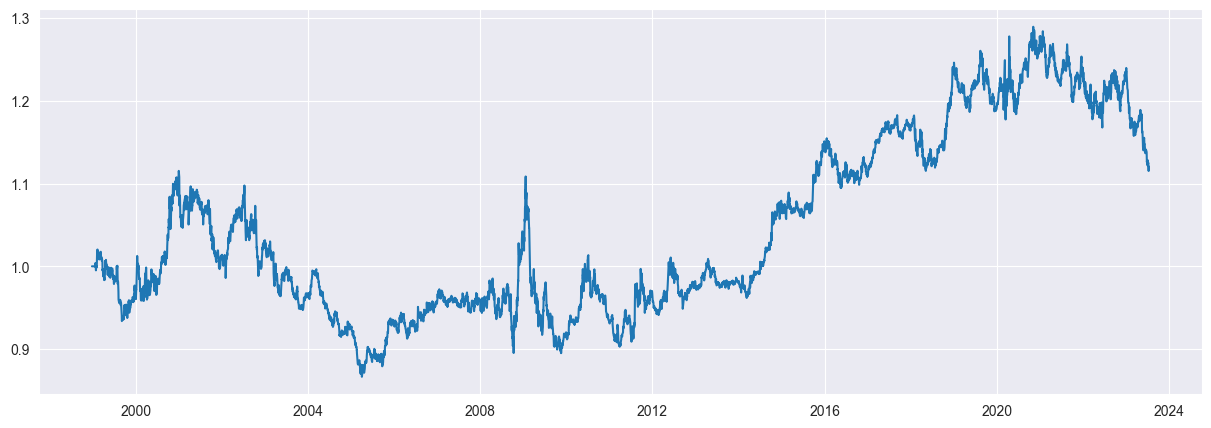

Assets contributing most to strategy (highest to lowest): 
XLV    0.210342
XLK    0.144674
XLP    0.138903
XLU    0.120989
XLY    0.082191
XLF   -0.000039
XLB   -0.042726
XLE   -0.238866
XLI   -0.247090
dtype: float64


In [16]:
def backtest(dataframe, highest_sharpe):
    lookback = lookbacks[highest_sharpe]

    print('Best Lookback Window', lookback)

    weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

    signal = dataframe.rolling(lookback).std()
    signal = signal.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
    signal = np.sign(signal)
    signal *= -1

    weighted_signal = signal.mul(weights)

    portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
    cumulative_returns = (portfolio_returns + 1).cumprod()
    plt.plot(cumulative_returns)

    # print sharpe to three decimal places
    print('Sharpe', round((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)), 3))

    plt.show()

    column_returns = (weighted_signal.shift() * dataframe).sum()
    print('Assets contributing most to strategy (highest to lowest): ')
    print(column_returns.sort_values(ascending=False))

backtest(normalizedDataframe, highest_sharpe)

# Notes

The performance of this strat is the most interesting, because the long only version of this strategy does really well, but this (long/short) version does horribly, I wonder why? Maybe predicting volatility for the market factor is more effective when using the cross-sectional volatility of sectors. The best lookback parameter for this long/short cross sectional low volatility strategy is 17 days, the highest returning sector is the health care select sector.